In [18]:
import praw
import os
import requests
import csv
import pandas as pd
import urllib
import re
import random
import matplotlib.pyplot as plt

In [19]:
CLIENT_ID = "tfGXJma3moRz7NGvrNENtA"
CLIENT_SECRET = "mzMSqFgs4zBMk8ILetit8LNj84g5_A"
USER_AGENT = "Scrape473 by u/Rainet473"
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT,
)

In [3]:
print(reddit.user.me())

None


### Function to Extract Posts
Reddit posts are extracted including media when a keyword and a subreddit is mentioned.

In [4]:
def extract_info(subreddit_name, search_keyword, image_no, received_posts, num_posts=10):
    # Create a directory to save the downloaded media
    save_directory = 'media_downloads'
    os.makedirs(save_directory, exist_ok=True)
    print("Subreddit_name:", subreddit_name)
    print("Search_keyword:", search_keyword)
    
    # Iterate through the subreddit posts
    subreddit = reddit.subreddit(subreddit_name)
    try:
        search_results = list(subreddit.search(search_keyword, limit=num_posts))
        print(len(search_results))
    except:
        return image_no
    
    non_media_posts = 3
    for post in search_results:   ##Considering new posts for the time being
        
        if post.url in received_posts:
            print("Duplicate Post found")
            continue
        else:
            received_posts.add(post.url)
            
        video_url = None
        image_url = None
        media_url = None
        media = []
        obtained_data = [search_keyword, str(post.url), str(post.title.encode('ascii', 'ignore'))]
        flag = False
        ##To check for media other than images
        if post.media:
            try:
                if 'reddit_video' in post.media:
                    # Download videos
                    video_url = post.media['reddit_video']['fallback_url']
                    file_extension = '.mp4'
                    save_path = os.path.join(save_directory, f'{post.id}{file_extension}')
                    response = requests.get(video_url)
                    with open(save_path, 'wb') as f:
                        f.write(response.content)
                    flag = True
                    print(f"Video downloaded: {post.id}{file_extension}")
                    media.append(f'{post.id}{file_extension}')
                    #obtained_data.append(f'{post.id}{file_extension}')
                elif 'oembed' in post.media:
                    # Download media from oembed
                    media_url = post.media['oembed']['url']
                    file_extension = os.path.splitext(media_url)[1]
                    save_path = os.path.join(save_directory, f'{post.id}{file_extension}')
                    response = requests.get(media_url)
                    with open(save_path, 'wb') as f:
                        f.write(response.content)
                    flag = True
                    print(f"Media downloaded: {post.id}{file_extension}")
                    media.append(f'{post.id}{file_extension}')
                    #obtained_data.append(f'{post.id}{file_extension}')
            except:
                continue
        
        ##If post has a single image
        if post.url.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            # Download images
            image_url = post.url
            file_extension = os.path.splitext(image_url)[1]
            save_path = os.path.join(save_directory, f'Image{image_no}{file_extension}')
            response = requests.get(image_url)
            with open(save_path, 'wb') as f:
                f.write(response.content)
            Flag = True
            print(f"Image downloaded: Image{image_no}")
            media.append(f'Image{image_no}{file_extension}')
            #obtained_data.append(f'{post.id}{file_extension}')
            image_no+=1
        try:
        ##If post has multiple images
            if post.media_metadata:
                # Iterate over the media metadata
                for media_id, media_data in post.media_metadata.items():
                    # Check if the media type is an image
                    if media_data.get('e') == 'Image':
                        # Get the image URL
                        image_url = media_data['s']['u']

                        # Download the image
                        response = requests.get(image_url)
                        if response.status_code == 200:
                            # Save the image to a file
                            save_path = os.path.join(save_directory, f'Image{image_no}.jpg')
                            with open(f'{save_path}', 'wb') as file:
                                file.write(response.content)
                            flag = True
                            print(f"Image{image_no} downloaded.")  
                            media.append(f'Image{image_no}.jpg')
                            image_no+=1
        except:
            pass
        ##To obtain images from comments
        try:
            for comment in post.comments.list():
                # Check if the comment has a body and contains URLs
                if comment.body and comment.body_html and comment.author == post.author.name:
                    # Extract URLs from the comment body
                    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', comment.body)
                    #print(urls)
                    # Download the images from the URLs
                    for url in urls:
                        # Check if the URL points to an image
                        if '.jpg' in url or '.jpeg' in url or '.png' in url or '.gif' in url:
                            try:
                                # Send a GET request to download the image
                                response = requests.get(url)
                                if response.status_code == 200:
                                    # Save the image to a file
                                    filename = url.split('/')[-1]
                                    filename = filename.split('?')[0]
                                    filename = filename.split(')')[0]
                                    file_extension = '.jpg' if '.jpg' in url else '.jpeg' if '.jpeg' in url else '.png' if '.png' in url else '.gif' if '.gif' in url else ''
                                    save_path = os.path.join(save_directory, f'Image{image_no}{file_extension}')
                                    with open(save_path, 'wb') as file:
                                        file.write(response.content)
                                    flag = True
                                    print(f"Image downloaded: Image{image_no}")
                                    media.append(f'Image{image_no}{file_extension}')
                                    image_no+=1
                            except requests.exceptions.RequestException as e:
                                print(f"Failed to download image from {url}: {e}")
        except:
            pass
        obtained_data.append(", ".join(media))
        
        if flag==False:
            if non_media_posts>0:
                non_media_posts-=1
            else:
                continue
            
        if len(str(post.selftext))>0:
            obtained_data.append(str(post.selftext.encode('ascii', 'ignore')))
        try:    
        #print(obtained_data)
            with open("reddit.csv", "a") as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(obtained_data)
            print("--------------------")
        except:
            if flag==False:
                non_media_posts+=1
        
    return image_no

In [13]:
Items = ["penicillin", "anticonvulsant", "allopurinol",
         "corticosteroid", "antimicrobial", "NSAID", "Tetracycline", "barbiturate", "codeine", "carbamezepine",
         "acetaminophen", "Advil"]
#"Drug reaction", "Unintended drug effects", 
Relating = ["rash" , "swelling", "itch", "problem", "side effect", "eyes", "vomit", "constipation"]

Subreddits = ["ADHD", "AskDocs", "DermatologyQuestions", "medicine", "DiagnoseMe", "Allergy", "Allergies", "bipolar",
              "gout", "psoriasis", "sciatica", "askdentists", "acne", "AcneScars", "Accutane", "mentalillnes",
              "mentalhealth", "skin", "headaches"]

In [35]:
##In case you want to rewrite
def rewrite(csv_name):
    with open(csv_name, "w") as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Keyword', 'Link', 'Title', 'Media', 'Body'])

In [ ]:
image_no = 0
for key in Items:
    for relating_key in Relating:
        for subreddit in Subreddits:
            image_no = extract_info(subreddit, key+" "+relating_key, image_no, num_posts = 10)

Subreddit_name: ADHD
Search_keyword: penicillin rash
1
--------------------
Subreddit_name: AskDocs
Search_keyword: penicillin rash
Subreddit_name: DermatologyQuestions
Search_keyword: penicillin rash
4
Image0 downloaded.
Image1 downloaded.
Image2 downloaded.
Image3 downloaded.
--------------------
Image4 downloaded.
Image5 downloaded.
Image6 downloaded.
Image7 downloaded.
Image8 downloaded.
Image9 downloaded.
--------------------
Image10 downloaded.
Image11 downloaded.
Image12 downloaded.
Image13 downloaded.
Image14 downloaded.
Image15 downloaded.
Image16 downloaded.
Image17 downloaded.
--------------------
Image18 downloaded.
--------------------
Subreddit_name: medicine
Search_keyword: penicillin rash
Subreddit_name: DiagnoseMe
Search_keyword: penicillin rash
6
Image downloaded: Image19
--------------------
--------------------
--------------------
Image20 downloaded.
Image21 downloaded.
Image22 downloaded.
Image23 downloaded.
Image24 downloaded.
Image25 downloaded.
Image26 download

Subreddit_name: askdentists
Search_keyword: penicillin side effect
10
--------------------
Image downloaded: Image54
--------------------
--------------------
Subreddit_name: acne
Search_keyword: penicillin side effect
10
Image55 downloaded.
Image56 downloaded.
Image57 downloaded.
Image58 downloaded.
Image59 downloaded.
--------------------
Image60 downloaded.
Image61 downloaded.
Image62 downloaded.
Image63 downloaded.
Image64 downloaded.
--------------------
--------------------
--------------------
--------------------
Subreddit_name: AcneScars
Search_keyword: penicillin side effect
10
--------------------
--------------------
--------------------
Image downloaded: Image65
Subreddit_name: Accutane
Search_keyword: penicillin side effect
10
--------------------
--------------------
--------------------
Image66 downloaded.
Image67 downloaded.
Image68 downloaded.
Image69 downloaded.
Image70 downloaded.
Image71 downloaded.
--------------------
Image72 downloaded.
Image73 downloaded.
Image

0
Subreddit_name: AskDocs
Search_keyword: anticonvulsant itch
Subreddit_name: DermatologyQuestions
Search_keyword: anticonvulsant itch
0
Subreddit_name: medicine
Search_keyword: anticonvulsant itch
Subreddit_name: DiagnoseMe
Search_keyword: anticonvulsant itch
0
Subreddit_name: Allergy
Search_keyword: anticonvulsant itch
0
Subreddit_name: Allergies
Search_keyword: anticonvulsant itch
0
Subreddit_name: bipolar
Search_keyword: anticonvulsant itch
1
--------------------
Subreddit_name: gout
Search_keyword: anticonvulsant itch
Subreddit_name: psoriasis
Search_keyword: anticonvulsant itch
0
Subreddit_name: sciatica
Search_keyword: anticonvulsant itch
0
Subreddit_name: askdentists
Search_keyword: anticonvulsant itch
0
Subreddit_name: acne
Search_keyword: anticonvulsant itch
0
Subreddit_name: AcneScars
Search_keyword: anticonvulsant itch
0
Subreddit_name: Accutane
Search_keyword: anticonvulsant itch
0
Subreddit_name: mentalillnes
Search_keyword: anticonvulsant itch
Subreddit_name: mentalhealt

0
Subreddit_name: skin
Search_keyword: anticonvulsant vomit
Subreddit_name: headaches
Search_keyword: anticonvulsant vomit
0
Subreddit_name: ADHD
Search_keyword: anticonvulsant constipation
0
Subreddit_name: AskDocs
Search_keyword: anticonvulsant constipation
Subreddit_name: DermatologyQuestions
Search_keyword: anticonvulsant constipation
0
Subreddit_name: medicine
Search_keyword: anticonvulsant constipation
Subreddit_name: DiagnoseMe
Search_keyword: anticonvulsant constipation
0
Subreddit_name: Allergy
Search_keyword: anticonvulsant constipation
0
Subreddit_name: Allergies
Search_keyword: anticonvulsant constipation
0
Subreddit_name: bipolar
Search_keyword: anticonvulsant constipation
0
Subreddit_name: gout
Search_keyword: anticonvulsant constipation
Subreddit_name: psoriasis
Search_keyword: anticonvulsant constipation
0
Subreddit_name: sciatica
Search_keyword: anticonvulsant constipation
0
Subreddit_name: askdentists
Search_keyword: anticonvulsant constipation
0
Subreddit_name: acne


--------------------
--------------------
--------------------
--------------------
Subreddit_name: AcneScars
Search_keyword: allopurinol side effect
10
--------------------
--------------------
--------------------
Image downloaded: Image141
Subreddit_name: Accutane
Search_keyword: allopurinol side effect
10
--------------------
--------------------
--------------------
Image142 downloaded.
Image143 downloaded.
Image144 downloaded.
Image145 downloaded.
Image146 downloaded.
Image147 downloaded.
--------------------
Image148 downloaded.
Image149 downloaded.
Image150 downloaded.
--------------------
Image downloaded: Image151
Image downloaded: Image152
Image153 downloaded.
Image154 downloaded.
--------------------
Subreddit_name: mentalillnes
Search_keyword: allopurinol side effect
Subreddit_name: mentalhealth
Search_keyword: allopurinol side effect
10
--------------------
--------------------
--------------------
Subreddit_name: skin
Search_keyword: allopurinol side effect
Subreddit_nam

2
--------------------
--------------------
Subreddit_name: acne
Search_keyword: corticosteroid swelling
0
Subreddit_name: AcneScars
Search_keyword: corticosteroid swelling
0
Subreddit_name: Accutane
Search_keyword: corticosteroid swelling
1
--------------------
Subreddit_name: mentalillnes
Search_keyword: corticosteroid swelling
Subreddit_name: mentalhealth
Search_keyword: corticosteroid swelling
0
Subreddit_name: skin
Search_keyword: corticosteroid swelling
Subreddit_name: headaches
Search_keyword: corticosteroid swelling
0
Subreddit_name: ADHD
Search_keyword: corticosteroid itch
0
Subreddit_name: AskDocs
Search_keyword: corticosteroid itch
Subreddit_name: DermatologyQuestions
Search_keyword: corticosteroid itch
10
Image179 downloaded.
Image180 downloaded.
Image181 downloaded.
Image182 downloaded.
--------------------
Image downloaded: Image183
--------------------
Image184 downloaded.
Image185 downloaded.
Image186 downloaded.
--------------------
Image187 downloaded.
Image188 downlo

10
--------------------
--------------------
--------------------
Subreddit_name: skin
Search_keyword: corticosteroid side effect
Subreddit_name: headaches
Search_keyword: corticosteroid side effect
10
--------------------
--------------------
--------------------
Subreddit_name: ADHD
Search_keyword: corticosteroid eyes
0
Subreddit_name: AskDocs
Search_keyword: corticosteroid eyes
Subreddit_name: DermatologyQuestions
Search_keyword: corticosteroid eyes
3
Image261 downloaded.
Image262 downloaded.
Image263 downloaded.
Image264 downloaded.
--------------------
Image265 downloaded.
Image266 downloaded.
--------------------
--------------------
Subreddit_name: medicine
Search_keyword: corticosteroid eyes
Subreddit_name: DiagnoseMe
Search_keyword: corticosteroid eyes
5
--------------------
--------------------
--------------------
Subreddit_name: Allergy
Search_keyword: corticosteroid eyes
1
--------------------
Subreddit_name: Allergies
Search_keyword: corticosteroid eyes
10
---------------

Subreddit_name: headaches
Search_keyword: antimicrobial itch
0
Subreddit_name: ADHD
Search_keyword: antimicrobial problem
1
--------------------
Subreddit_name: AskDocs
Search_keyword: antimicrobial problem
Subreddit_name: DermatologyQuestions
Search_keyword: antimicrobial problem
1
--------------------
Subreddit_name: medicine
Search_keyword: antimicrobial problem
Subreddit_name: DiagnoseMe
Search_keyword: antimicrobial problem
0
Subreddit_name: Allergy
Search_keyword: antimicrobial problem
0
Subreddit_name: Allergies
Search_keyword: antimicrobial problem
0
Subreddit_name: bipolar
Search_keyword: antimicrobial problem
0
Subreddit_name: gout
Search_keyword: antimicrobial problem
Subreddit_name: psoriasis
Search_keyword: antimicrobial problem
Subreddit_name: sciatica
Search_keyword: antimicrobial problem
0
Subreddit_name: askdentists
Search_keyword: antimicrobial problem
3
--------------------
--------------------
--------------------
Subreddit_name: acne
Search_keyword: antimicrobial p

Subreddit_name: DermatologyQuestions
Search_keyword: NSAID rash
1
--------------------
Subreddit_name: medicine
Search_keyword: NSAID rash
Subreddit_name: DiagnoseMe
Search_keyword: NSAID rash
10
--------------------
--------------------
--------------------
Image297 downloaded.
Image298 downloaded.
Image299 downloaded.
Image300 downloaded.
--------------------
Subreddit_name: Allergy
Search_keyword: NSAID rash
0
Subreddit_name: Allergies
Search_keyword: NSAID rash
1
--------------------
Subreddit_name: bipolar
Search_keyword: NSAID rash
0
Subreddit_name: gout
Search_keyword: NSAID rash
Subreddit_name: psoriasis
Search_keyword: NSAID rash
Subreddit_name: sciatica
Search_keyword: NSAID rash
1
--------------------
Subreddit_name: askdentists
Search_keyword: NSAID rash
0
Subreddit_name: acne
Search_keyword: NSAID rash
0
Subreddit_name: AcneScars
Search_keyword: NSAID rash
0
Subreddit_name: Accutane
Search_keyword: NSAID rash
0
Subreddit_name: mentalillnes
Search_keyword: NSAID rash
Subred

--------------------
Subreddit_name: ADHD
Search_keyword: NSAID eyes
1
--------------------
Subreddit_name: AskDocs
Search_keyword: NSAID eyes
Subreddit_name: DermatologyQuestions
Search_keyword: NSAID eyes
1
--------------------
Subreddit_name: medicine
Search_keyword: NSAID eyes
Subreddit_name: DiagnoseMe
Search_keyword: NSAID eyes
9
--------------------
--------------------
--------------------
Image332 downloaded.
Image333 downloaded.
Image334 downloaded.
Image335 downloaded.
--------------------
Subreddit_name: Allergy
Search_keyword: NSAID eyes
0
Subreddit_name: Allergies
Search_keyword: NSAID eyes
5
--------------------
--------------------
--------------------
Subreddit_name: bipolar
Search_keyword: NSAID eyes
0
Subreddit_name: gout
Search_keyword: NSAID eyes
Subreddit_name: psoriasis
Search_keyword: NSAID eyes
Subreddit_name: sciatica
Search_keyword: NSAID eyes
3
--------------------
--------------------
--------------------
Subreddit_name: askdentists
Search_keyword: NSAID ey

0
Subreddit_name: ADHD
Search_keyword: Tetracycline problem
1
--------------------
Subreddit_name: AskDocs
Search_keyword: Tetracycline problem
Subreddit_name: DermatologyQuestions
Search_keyword: Tetracycline problem
1
Image357 downloaded.
Image358 downloaded.
Image359 downloaded.
Image360 downloaded.
--------------------
Subreddit_name: medicine
Search_keyword: Tetracycline problem
Subreddit_name: DiagnoseMe
Search_keyword: Tetracycline problem
1
--------------------
Subreddit_name: Allergy
Search_keyword: Tetracycline problem
1
Image361 downloaded.
Image362 downloaded.
Image363 downloaded.
Image364 downloaded.
--------------------
Subreddit_name: Allergies
Search_keyword: Tetracycline problem
0
Subreddit_name: bipolar
Search_keyword: Tetracycline problem
0
Subreddit_name: gout
Search_keyword: Tetracycline problem
Subreddit_name: psoriasis
Search_keyword: Tetracycline problem
Subreddit_name: sciatica
Search_keyword: Tetracycline problem
0
Subreddit_name: askdentists
Search_keyword: T

0
Subreddit_name: Accutane
Search_keyword: Tetracycline constipation
0
Subreddit_name: mentalillnes
Search_keyword: Tetracycline constipation
Subreddit_name: mentalhealth
Search_keyword: Tetracycline constipation
0
Subreddit_name: skin
Search_keyword: Tetracycline constipation
Subreddit_name: headaches
Search_keyword: Tetracycline constipation
0
Subreddit_name: ADHD
Search_keyword: barbiturate rash
0
Subreddit_name: AskDocs
Search_keyword: barbiturate rash
Subreddit_name: DermatologyQuestions
Search_keyword: barbiturate rash
0
Subreddit_name: medicine
Search_keyword: barbiturate rash
Subreddit_name: DiagnoseMe
Search_keyword: barbiturate rash
0
Subreddit_name: Allergy
Search_keyword: barbiturate rash
0
Subreddit_name: Allergies
Search_keyword: barbiturate rash
0
Subreddit_name: bipolar
Search_keyword: barbiturate rash
0
Subreddit_name: gout
Search_keyword: barbiturate rash
Subreddit_name: psoriasis
Search_keyword: barbiturate rash
Subreddit_name: sciatica
Search_keyword: barbiturate ra

Subreddit_name: DiagnoseMe
Search_keyword: barbiturate eyes
0
Subreddit_name: Allergy
Search_keyword: barbiturate eyes
0
Subreddit_name: Allergies
Search_keyword: barbiturate eyes
0
Subreddit_name: bipolar
Search_keyword: barbiturate eyes
0
Subreddit_name: gout
Search_keyword: barbiturate eyes
Subreddit_name: psoriasis
Search_keyword: barbiturate eyes
Subreddit_name: sciatica
Search_keyword: barbiturate eyes
0
Subreddit_name: askdentists
Search_keyword: barbiturate eyes
0
Subreddit_name: acne
Search_keyword: barbiturate eyes
0
Subreddit_name: AcneScars
Search_keyword: barbiturate eyes
0
Subreddit_name: Accutane
Search_keyword: barbiturate eyes
0
Subreddit_name: mentalillnes
Search_keyword: barbiturate eyes
Subreddit_name: mentalhealth
Search_keyword: barbiturate eyes
0
Subreddit_name: skin
Search_keyword: barbiturate eyes
Subreddit_name: headaches
Search_keyword: barbiturate eyes
0
Subreddit_name: ADHD
Search_keyword: barbiturate vomit
0
Subreddit_name: AskDocs
Search_keyword: barbitur

Subreddit_name: mentalhealth
Search_keyword: codeine problem
10
--------------------
--------------------
--------------------
Subreddit_name: skin
Search_keyword: codeine problem
Subreddit_name: headaches
Search_keyword: codeine problem
0
Subreddit_name: ADHD
Search_keyword: codeine side effect
10
--------------------
--------------------
--------------------
Subreddit_name: AskDocs
Search_keyword: codeine side effect
Subreddit_name: DermatologyQuestions
Search_keyword: codeine side effect
10
--------------------
--------------------
--------------------
Subreddit_name: medicine
Search_keyword: codeine side effect
Subreddit_name: DiagnoseMe
Search_keyword: codeine side effect
10
--------------------
--------------------
Image431 downloaded.
Image432 downloaded.
--------------------
--------------------
Image downloaded: Image433
Subreddit_name: Allergy
Search_keyword: codeine side effect
10
--------------------
Image downloaded: Image434
--------------------
--------------------
Subre

Subreddit_name: DermatologyQuestions
Search_keyword: carbamezepine swelling
0
Subreddit_name: medicine
Search_keyword: carbamezepine swelling
Subreddit_name: DiagnoseMe
Search_keyword: carbamezepine swelling
0
Subreddit_name: Allergy
Search_keyword: carbamezepine swelling
0
Subreddit_name: Allergies
Search_keyword: carbamezepine swelling
0
Subreddit_name: bipolar
Search_keyword: carbamezepine swelling
0
Subreddit_name: gout
Search_keyword: carbamezepine swelling
Subreddit_name: psoriasis
Search_keyword: carbamezepine swelling
Subreddit_name: sciatica
Search_keyword: carbamezepine swelling
0
Subreddit_name: askdentists
Search_keyword: carbamezepine swelling
0
Subreddit_name: acne
Search_keyword: carbamezepine swelling
0
Subreddit_name: AcneScars
Search_keyword: carbamezepine swelling
0
Subreddit_name: Accutane
Search_keyword: carbamezepine swelling
0
Subreddit_name: mentalillnes
Search_keyword: carbamezepine swelling
Subreddit_name: mentalhealth
Search_keyword: carbamezepine swelling
0


Subreddit_name: psoriasis
Search_keyword: carbamezepine vomit
Subreddit_name: sciatica
Search_keyword: carbamezepine vomit
0
Subreddit_name: askdentists
Search_keyword: carbamezepine vomit
0
Subreddit_name: acne
Search_keyword: carbamezepine vomit
0
Subreddit_name: AcneScars
Search_keyword: carbamezepine vomit
0
Subreddit_name: Accutane
Search_keyword: carbamezepine vomit
0
Subreddit_name: mentalillnes
Search_keyword: carbamezepine vomit
Subreddit_name: mentalhealth
Search_keyword: carbamezepine vomit
0
Subreddit_name: skin
Search_keyword: carbamezepine vomit
Subreddit_name: headaches
Search_keyword: carbamezepine vomit
0
Subreddit_name: ADHD
Search_keyword: carbamezepine constipation
0
Subreddit_name: AskDocs
Search_keyword: carbamezepine constipation
Subreddit_name: DermatologyQuestions
Search_keyword: carbamezepine constipation
0
Subreddit_name: medicine
Search_keyword: carbamezepine constipation
Subreddit_name: DiagnoseMe
Search_keyword: carbamezepine constipation
0
Subreddit_name:

--------------------
Subreddit_name: medicine
Search_keyword: acetaminophen side effect
Subreddit_name: DiagnoseMe
Search_keyword: acetaminophen side effect
10
--------------------
--------------------
Image498 downloaded.
Image499 downloaded.
--------------------
--------------------
Image downloaded: Image500
Subreddit_name: Allergy
Search_keyword: acetaminophen side effect
10
--------------------
Image downloaded: Image501
--------------------
--------------------
Subreddit_name: Allergies
Search_keyword: acetaminophen side effect
10
--------------------
--------------------
--------------------
Subreddit_name: bipolar
Search_keyword: acetaminophen side effect
10
--------------------
--------------------
--------------------
Image downloaded: Image502
Image downloaded: Image503
Subreddit_name: gout
Search_keyword: acetaminophen side effect
Subreddit_name: psoriasis
Search_keyword: acetaminophen side effect
Subreddit_name: sciatica
Search_keyword: acetaminophen side effect
10
-------

### Removing Duplicates from extracted posts and shuffling them

After extracting the posts from reddit. It was observed that some posts were repeated multiple times as well as their images were also downloaded multiple times. This is due to the presence of common keywords(provided in list) in the reddit posts.

You can run this cell anytime

In [75]:
posts = pd.read_csv('reddit.csv')
Links = {}
rows = []

for i in range(len(posts)):
    link = posts['Link'][i]
    keyword = posts['Keyword'][i]
    title = posts['Title'][i]
    media = "" if pd.isna(posts['Media'][i]) else posts['Media'][i]
    medias = [] if pd.isna(posts['Media'][i]) else posts['Media'][i].split(', ')
    body = posts['Body'][i]
    
    if link in Links:
        Links[link] += medias
    else:
        Links[link] = []
        rows.append([keyword, link, title, media, body])

print("Original Posts:",len(rows))
saved_directory = 'media_downloads'

total_duplicate_media = 0

for link in Links:
    if len(Links[link])>0:
        for image_name in Links[link]:
            if 'Image524' in image_name:
                print(image_name)
            path = os.path.join(saved_directory, image_name)
            if os.path.exists(path):
                os.remove(path)
            else:
                if os.path.exists(path+".jpg"):
                    os.remove(path+".jpg")
                elif os.path.exists(path+".jpeg"):
                    os.remove(path+".jpeg")
                elif os.path.exists(path+".png"):
                    os.remove(path+".png")
                elif os.path.exists(path+".gif"):
                    os.remove(path+".gif")
                else:
                    pass
            #if '.jpg' not in path or '.jpeg' not in path or '.png' not in path or '.gif' not in path:
            #os.remove(path)
    total_duplicate_media += len(Links[link])

random.shuffle(rows)    
rewrite('reddit.csv')
with open("reddit.csv", "a") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(rows)
    
    
print("Total Duplicate Posts Removed: ", len(posts)-len(rows))    
print("Total Duplicate Images Removed: ",total_duplicate_media)

Original Posts: 2200
Total Duplicate Posts Removed:  0
Total Duplicate Images Removed:  0


In [6]:
def collect_links(csvname):
    dataframe = pd.read_csv(csvname)
    Links = set()
    for link in dataframe['Link']:
        if link not in Links:
            Links.add(link)
        else:
            pass
    return Links

In [7]:
Items = ["influenza vaccine", "covid vaccine"]
 
Relating = ["rash" , "blood", "vomit", "eyes", "nausea", "pain", "discharge", ""]

Subreddits = ["ADHD", "AskDocs", "DermatologyQuestions", "medicine", "DiagnoseMe", "Allergies", "bipolar",  "Dentistry", "acne",
              "Accutane", "mentalhealth", "medical_advice", "insomnia", "ambien", "antidepressants", "Anxiety",
              "depression", "aspergers", "miagraine", "benzodiazepines"]

In [8]:
image_no = 1805
posts = collect_links('reddit.csv')
for key in Items:
    for relating_key in Relating:
        for subreddit in Subreddits:
            image_no = extract_info(subreddit, key+' '+relating_key, image_no, posts, num_posts = 10)
            
print(image_no)
    

Subreddit_name: ADHD
Search_keyword: influenza vaccine rash
1
--------------------
Subreddit_name: AskDocs
Search_keyword: influenza vaccine rash
10
--------------------
--------------------
--------------------
Subreddit_name: DermatologyQuestions
Search_keyword: influenza vaccine rash
10
Image downloaded: Image1805
--------------------
Image1806 downloaded.
Image1807 downloaded.
--------------------
--------------------
Image1808 downloaded.
Image1809 downloaded.
--------------------
Image1810 downloaded.
Image1811 downloaded.
--------------------
Image downloaded: Image1812
--------------------
Image1813 downloaded.
Image1814 downloaded.
--------------------
Image downloaded: Image1815
Duplicate Post found
Image1816 downloaded.
Image1817 downloaded.
Image1818 downloaded.
Image1819 downloaded.
Image1820 downloaded.
Image1821 downloaded.
Image1822 downloaded.
Image1823 downloaded.
Image1824 downloaded.
Image1825 downloaded.
Image1826 downloaded.
Image1827 downloaded.
Image1828 downloa

10
--------------------
--------------------
--------------------
Duplicate Post found
Subreddit_name: AskDocs
Search_keyword: influenza vaccine eyes
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
--------------------
--------------------
Subreddit_name: DermatologyQuestions
Search_keyword: influenza vaccine eyes
4
Duplicate Post found
Duplicate Post found
--------------------
--------------------
Subreddit_name: medicine
Search_keyword: influenza vaccine eyes
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Subreddit_name: DiagnoseMe
Search_keyword: influenza vaccine eyes
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
--------------------
---

10
--------------------
--------------------
--------------------
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: depression
Search_keyword: influenza vaccine pain
10
--------------------
--------------------
Duplicate Post found
--------------------
Duplicate Post found
Duplicate Post found
Subreddit_name: aspergers
Search_keyword: influenza vaccine pain
10
Duplicate Post found
--------------------
--------------------
--------------------
Duplicate Post found
Duplicate Post found
Subreddit_name: miagraine
Search_keyword: influenza vaccine pain
Subreddit_name: benzodiazepines
Search_keyword: influenza vaccine pain
2
--------------------
Duplicate Post found
Subreddit_name: ADHD
Search_keyword: influenza vaccine discharge
0
Subreddit_name: AskDocs
Search_keyword: influenza vaccine discharge
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
-----------------

Duplicate Post found
Subreddit_name: ambien
Search_keyword: covid vaccine rash
2
Image downloaded: Image1885
--------------------
Duplicate Post found
Subreddit_name: antidepressants
Search_keyword: covid vaccine rash
10
--------------------
--------------------
--------------------
Duplicate Post found
Duplicate Post found
Subreddit_name: Anxiety
Search_keyword: covid vaccine rash
10
--------------------
--------------------
Duplicate Post found
--------------------
Subreddit_name: depression
Search_keyword: covid vaccine rash
10
--------------------
--------------------
--------------------
Duplicate Post found
Duplicate Post found
Subreddit_name: aspergers
Search_keyword: covid vaccine rash
10
--------------------
--------------------
--------------------
Subreddit_name: miagraine
Search_keyword: covid vaccine rash
Subreddit_name: benzodiazepines
Search_keyword: covid vaccine rash
9
--------------------
--------------------
--------------------
Subreddit_name: ADHD
Search_keyword: c

5
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Subreddit_name: Accutane
Search_keyword: covid vaccine vomit
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
--------------------
Subreddit_name: mentalhealth
Search_keyword: covid vaccine vomit
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: medical_advice
Search_keyword: covid vaccine vomit
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Subreddit_name: insomnia
Search_keyword: covid vaccine vomit


10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: DermatologyQuestions
Search_keyword: covid vaccine nausea
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: medicine
Search_keyword: covid vaccine nausea
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: DiagnoseMe
Search_keyword: covid vaccine nausea
10
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Duplicate P

2
Duplicate Post found
Duplicate Post found
Subreddit_name: antidepressants
Search_keyword: covid vaccine pain
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Subreddit_name: Anxiety
Search_keyword: covid vaccine pain
10
--------------------
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: depression
Search_keyword: covid vaccine pain
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
--------------------
--------------------
Duplicate Post found
Duplicate Post found
Subreddit_name: aspergers
Search_keyword: covid vaccine pain
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Du

--------------------
--------------------
Duplicate Post found
--------------------
Subreddit_name: Dentistry
Search_keyword: covid vaccine 
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: acne
Search_keyword: covid vaccine 
4
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: Accutane
Search_keyword: covid vaccine 
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Subreddit_name: mentalhealth
Search_keyword: covid vaccine 
10
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
Duplicate Post found
--------------------
--------

### Finding Stats for keywords

In [71]:
def find_stats(filename):
    dataframe = pd.read_csv(filename)
    keyword_stats = {}
    keywords = dataframe['Keyword']
    for i in range(len(keywords)):
        if keywords[i].split()[0] not in keyword_stats:
            keyword_stats[keywords[i].split()[0]] = 1
        else:
            keyword_stats[keywords[i].split()[0]] += 1
    return keyword_stats, len(keywords)
print(find_stats('reddit.csv'))

({'ambien': 27, 'influenza': 124, 'neurontin': 21, 'Tetracycline': 15, 'Advil': 49, 'aspirin': 32, 'tramadol': 27, 'dilaudid': 22, 'meloxicam': 16, 'ativan': 25, 'depakote': 23, 'benadryl': 41, 'phentermine': 20, 'gabapentin': 35, 'ibuprofen': 37, 'cymbalta': 30, 'dexilant': 12, 'atenolol': 19, 'anticonvulsant': 13, 'amitriptyline': 31, 'NSAID': 36, 'prozac': 35, 'creatine': 31, 'keppra': 21, '5-htp': 22, 'prednisone': 41, 'metronidazole': 30, 'methadone': 23, 'covid': 105, 'bactrim': 27, 'effexor': 32, 'wellbutrin': 31, 'penicillin': 57, 'hydrocodone-acetaminophen': 14, 'codeine': 26, 'celexa': 25, 'ashwagandha': 27, 'namenda': 9, 'azithromycin': 22, 'cipro': 21, 'levothyroxine': 27, 'hydroxyzine': 32, 'abilify': 26, 'amoxicillin': 37, 'buspirone': 22, 'lexapro': 32, 'dicyclomine': 13, 'emgality': 8, 'clindamycin': 28, 'nortriptyline': 21, 'baclofen': 23, 'celebrex': 18, 'astaxanthin': 10, 'cialis': 17, 'lisinopril': 19, 'biotin': 31, 'warfarin': 14, 'citalopram': 27, 'crestor': 10, '

In [72]:
from math import ceil

keyword_stats, total = find_stats('reddit.csv')
ratios = {keyword : keyword_stats[keyword]/total for keyword in keyword_stats}
m = 2158
reduced_shares = {keyword : ceil(ratios[keyword]*m) for keyword in ratios}
print(reduced_shares)
reduced_total = 0
for keyword in reduced_shares:
    reduced_total += reduced_shares[keyword]
print("Total Number of Posts after reduction: ", reduced_total)

{'ambien': 27, 'influenza': 122, 'neurontin': 21, 'Tetracycline': 15, 'Advil': 49, 'aspirin': 32, 'tramadol': 27, 'dilaudid': 22, 'meloxicam': 16, 'ativan': 25, 'depakote': 23, 'benadryl': 41, 'phentermine': 20, 'gabapentin': 35, 'ibuprofen': 37, 'cymbalta': 30, 'dexilant': 12, 'atenolol': 19, 'anticonvulsant': 13, 'amitriptyline': 31, 'NSAID': 36, 'prozac': 35, 'creatine': 31, 'keppra': 21, '5-htp': 22, 'prednisone': 41, 'metronidazole': 30, 'methadone': 23, 'covid': 103, 'bactrim': 27, 'effexor': 32, 'wellbutrin': 31, 'penicillin': 56, 'hydrocodone-acetaminophen': 14, 'codeine': 26, 'celexa': 25, 'ashwagandha': 27, 'namenda': 9, 'azithromycin': 22, 'cipro': 21, 'levothyroxine': 27, 'hydroxyzine': 32, 'abilify': 26, 'amoxicillin': 37, 'buspirone': 22, 'lexapro': 32, 'dicyclomine': 13, 'emgality': 8, 'clindamycin': 28, 'nortriptyline': 21, 'baclofen': 23, 'celebrex': 18, 'astaxanthin': 10, 'cialis': 17, 'lisinopril': 19, 'biotin': 31, 'warfarin': 14, 'citalopram': 27, 'crestor': 10, 'm

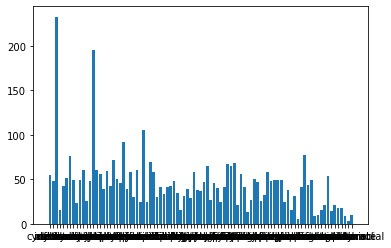

In [63]:
plt.bar(range(len(keyword_stats)), list(keyword_stats.values()), tick_label=list(keyword_stats.keys()))
plt.show()

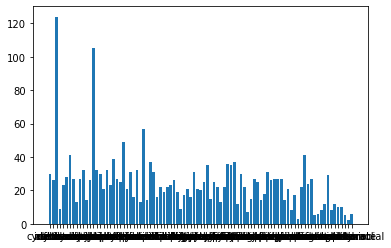

In [64]:
plt.bar(range(len(reduced_shares)), list(reduced_shares.values()), tick_label=list(reduced_shares.keys()))
plt.show()

In [70]:
max_image_ratio = 0
key = ''
image_ratios = {}
data_with_image = {}
data_without_image = {}
data = pd.read_csv('reddit.csv')
for i in range(len(data)):
    keyword = data['Keyword'][i]
    link = data['Link'][i]
    title = data['Title'][i]
    media = data['Media'][i]
    body = data['Body'][i]
    
    if keyword.split()[0] in image_ratios:
        image_ratios[keyword.split()[0]][1] += 1
        if pd.isna(media)==False:
            image_ratios[keyword.split()[0]][0] += 1
            data_with_image[keyword.split()[0]].append((keyword.split()[0], link, title, media, body))
        else:
            data_without_image[keyword.split()[0]].append((keyword.split()[0], link, title, '', body))
            
    else:
        image_ratios[keyword.split()[0]] = [0, 1]
        if pd.isna(media)==False:
            image_ratios[keyword.split()[0]][0] += 1
            data_with_image[keyword.split()[0]] = [(keyword.split()[0], link, title, media, body)]
            data_without_image[keyword.split()[0]] = []
        else:
            data_without_image[keyword.split()[0]] = [(keyword.split()[0], link, title, '', body)]
            data_with_image[keyword.split()[0]] = []
            
##Finding Max Ratio
for word in image_ratios:
    image_ratios[word] = round(image_ratios[word][0]/image_ratios[word][1], 2)
    if image_ratios[word]>max_image_ratio:
        max_image_ratio = image_ratios[word]
        key = word

print("Dictionary of Ratios:\n\n", image_ratios, "\n")
print("Maximum Ratio of posts w/ Image to posts w/o Images for a keyword: ",max_image_ratio,"\nKey containing the maximum ratio: ", key)

imaged_datas = 0
for i in list(data_with_image.values()):
    imaged_datas += len(i)
print('Posts with images: ', imaged_datas)

non_imaged_datas = 0
for i in list(data_without_image.values()):
    non_imaged_datas += len(i)
print('Posts without images: ', non_imaged_datas)

Dictionary of Ratios:

 {'ambien': 0.26, 'influenza': 0.12, 'neurontin': 0.19, 'Tetracycline': 0.4, 'Advil': 0.22, 'aspirin': 0.31, 'tramadol': 0.11, 'dilaudid': 0.27, 'meloxicam': 0.12, 'ativan': 0.08, 'depakote': 0.0, 'benadryl': 0.71, 'phentermine': 0.1, 'gabapentin': 0.23, 'ibuprofen': 0.46, 'cymbalta': 0.07, 'dexilant': 0.17, 'atenolol': 0.05, 'anticonvulsant': 0.15, 'amitriptyline': 0.39, 'NSAID': 0.06, 'prozac': 0.29, 'creatine': 0.32, 'keppra': 0.1, '5-htp': 0.14, 'prednisone': 0.73, 'metronidazole': 0.7, 'methadone': 0.17, 'covid': 0.24, 'bactrim': 0.67, 'effexor': 0.22, 'wellbutrin': 0.13, 'penicillin': 0.35, 'hydrocodone-acetaminophen': 0.07, 'codeine': 0.08, 'celexa': 0.08, 'ashwagandha': 0.26, 'namenda': 0.0, 'azithromycin': 0.45, 'cipro': 0.19, 'levothyroxine': 0.26, 'hydroxyzine': 0.31, 'abilify': 0.08, 'amoxicillin': 0.7, 'buspirone': 0.09, 'lexapro': 0.19, 'dicyclomine': 0.0, 'emgality': 0.12, 'clindamycin': 0.57, 'nortriptyline': 0.05, 'baclofen': 0.17, 'celebrex': 0.

In [66]:
rewrite('reddit.csv')
with open('reddit.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    for rows in data_with_image:
        csvwriter.writerows(data_with_image[rows])
        reduced_shares[rows] -= len(data_with_image[rows])

print(reduced_shares)

{'cymbalta': 28, 'lyrica': 20, 'influenza': 109, 'namenda': 9, 'methadone': 19, 'clindamycin': 12, 'benadryl': 12, 'acetaminophen': 23, 'anticonvulsant': 11, 'trazodone': 26, 'hydroxyzine': 22, 'lipitor': 11, 'codeine': 24, 'covid': 80, 'lexapro': 26, 'metronidazole': 9, 'cipro': 17, 'aspirin': 22, 'baclofen': 19, 'corticosteroid': 14, 'bactrim': 9, 'lorazepam': 24, 'Advil': 38, 'neurontin': 17, 'wellbutrin': 27, 'methylprednisolone': 14, 'effexor': 25, 'dicyclomine': 13, 'penicillin': 37, 'macrobid': 13, 'amoxicillin': 11, 'creatine': 21, 'meloxicam': 14, 'prilosec': 22, 'atenolol': 18, 'dilaudid': 16, 'depakote': 23, 'abilify': 24, 'lisinopril': 18, 'trulicity': 9, 'flagyl': 13, 'keppra': 19, 'losartan': 15, 'biotin': 22, 'nortriptyline': 20, 'phentermine': 18, 'clonazepam': 23, 'gabapentin': 27, 'plaquenil': 12, 'celexa': 23, 'azithromycin': 12, 'hydrochlorothiazide': 11, '5-htp': 19, 'NSAID': 34, 'prozac': 25, 'ibuprofen': 20, 'dexilant': 10, 'morphine': 20, 'cyclobenzaprine': 19, 

In [67]:
reduced_total = 0
for keyword in reduced_shares:
    reduced_total += reduced_shares[keyword]
print("Total Number of Posts after reduction: ", reduced_total)

Total Number of Posts after reduction:  1699


In [68]:
with open('reddit.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    for keyword in data_without_image:
        n = reduced_shares[keyword]
        random.shuffle(data_without_image[keyword])
        csvwriter.writerows(data_without_image[keyword][:n])


In [73]:
rewrite('reddit.csv')

with open('reddit.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    for rows in data_with_image:
        csvwriter.writerows(data_with_image[rows])

with open('reddit.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile)
    for rows in data_without_image:
        csvwriter.writerows(data_without_image[rows])
    